In [1]:
import torch
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from torch import nn

This code is based on the paper "Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations" by Maziar Raissi, Paris Perdikaris, and George Em Karniadakis

### NOTE
bci: boundary and initial conditions<br><br>
coll: collocation

## define the PINN and loss

In [2]:
class BurgerMSE(nn.Module):
    def __init__(self):
        super(BurgerMSE, self).__init__()
        self.loss = None
        
    def MSE_u(self, u_pred, u_targets):
        return torch.mean((u_pred - u_targets)**2)
    
    def MSE_f(self, f_pred):
        return torch.mean(f_pred**2)

    def calc_loss(self, u_pred, u_targets, f_pred):
        loss_u = self.MSE_u(u_pred, u_targets)
        loss_f = self.MSE_f(f_pred)
        loss = loss_u + loss_f
        
        return loss, loss_u, loss_f
    
class BurgerPINN(nn.Module):
    def __init__(self, input_size, optimizer_lr=0.0001):
        super(BurgerPINN, self).__init__()
        self.dense0 = nn.Linear(input_size, 20, dtype=torch.double)
        self.tanh = nn.Tanh()
        self.dense1 = nn.Linear(20, 20, dtype=torch.double)
        self.dense2 = nn.Linear(20, 20, dtype=torch.double)
        self.dense3 = nn.Linear(20, 20, dtype=torch.double)
        self.dense4 = nn.Linear(20, 20, dtype=torch.double)
        self.dense5 = nn.Linear(20, 20, dtype=torch.double)
        self.dense6 = nn.Linear(20, 20, dtype=torch.double)
        self.dense7 = nn.Linear(20, 20, dtype=torch.double)
        self.dense_out = nn.Linear(20, 1, dtype=torch.double)

        self.optimizer = optim.Adam(self.parameters(), lr=optimizer_lr, betas=(0.9, 0.98), eps=1e-9)
        self.loss_criteria = BurgerMSE()
        self.loss = None
        self.loss_u = None
        self.loss_f = None
        
    def forward(self, data):
        out = self.dense0(data)
        out = self.tanh(out)
        out = self.dense1(out)
        out = self.tanh(out)
        out = self.dense2(out)
        out = self.tanh(out)
        out = self.dense3(out)
        out = self.tanh(out)
        out = self.dense4(out)
        out = self.tanh(out)
        out = self.dense5(out)
        out = self.tanh(out)
        out = self.dense6(out)
        out = self.tanh(out)
        out = self.dense7(out)
        out = self.tanh(out)
        out = self.dense_out(out)
        
        return out
        
    def forward_bci(self, x_bci, t_bci):
        # pass through nn
        u = self.forward(torch.cat([x_bci, t_bci], dim=1))
        
        return u
    
    def forward_coll(self, x_coll, t_coll):
        # pass through nn
        u = self.forward(torch.cat([x_coll, t_coll], dim=1))
        
        # calc gradients
        u_t = torch.autograd.grad(u, t_coll, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x_coll, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_coll, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        
        # EOM
        f = u_t + u * u_x - (0.01 / np.pi) * u_xx
        
        return f

    def backward(self, u_pred, u_targets, f_pred, test_pass=False):
        # calc loss
        self.loss, self.loss_u, self.loss_f = self.loss_criteria.calc_loss(u_pred, u_targets, f_pred)

        # backprop + update params
        if not test_pass:
            self.optimizer.zero_grad()
            self.loss.backward()
            self.optimizer.step()

        return self.loss, self.loss_u, self.loss_f

## generate data

In [3]:
def generate_train_test(N, t_0_prop, x_min_bc_prop, x_max_bc_prop, t_min, t_max, x_min, x_max, device, test_prop=0.2):    
    """
    Generates boundary/initial condition and collocation data. 
    Returns 4 tensors:
    boundary/initial condition train, boundary/initial condtion test, collocation train,
    collocation test

    N: total number of samples to generate
    t_0_prop: proportion of N that should be t=0 data
    x_min_bc_prop: proportion of N that should be x=x_min data
    x_max_bc_prop: proportion of N that should be x=x_max data
    t_min: minimum t value
    t_max: maximum t value
    x_min: minimum x value
    x_max: maximum x value
    device: pytorch device to put tensors on (should be cpu or cuda device)
    test_prop: proportion of generated data to be split into test data (defaults to 0.2)
    """

    # determine the number of each data type to generate
    t_0_N = int(N * t_0_prop)
    x_min_N = int(N * x_min_bc_prop)
    x_max_N = int(N * x_max_bc_prop)
    x_delta = 0.01  # add/subtract from x_min and x_max later to ensure min or max vals not used
    t_delta = 0.01  # same deal as x_delta
    coll_N = N - (t_0_N + x_min_N + x_max_N)  # all other points in range

    # generate x and u(x, t) values at t=0 (t_min)
    x_bci = np.random.uniform(low=x_min + x_delta, high=x_max - x_delta, size=t_0_N)
    t_bci = np.array([0.] * t_0_N)
    u_bci = -np.sin(np.pi * x_bci)

    # generate t and u(x, t) values at x=-1 (x_min)
    x_bci = np.concatenate([x_bci, np.array([x_min] * x_min_N)])
    t_bci = np.concatenate([t_bci, np.random.uniform(low=t_min + t_delta, high=t_max - t_delta, size=x_min_N)])
    u_bci = np.concatenate([u_bci, np.array([0.] * x_min_N)])

    # generate t and u(x, t) values at x=1 (x_max)
    x_bci = np.concatenate([x_bci, np.array([x_max] * x_max_N)])
    t_bci = np.concatenate([t_bci, np.random.uniform(low=t_min + t_delta, high=t_max - t_delta, size=x_max_N)])
    u_bci = np.concatenate([u_bci, np.array([0.] * x_max_N)])

    # generate coll points
    x_coll = np.random.uniform(low=x_min + x_delta, high=x_max - x_delta, size=coll_N) 
    t_coll = np.random.uniform(low=t_min + t_delta, high=t_max - t_delta, size=coll_N) 

    # reshape and concat x and t data at b.c. and initial t
    # each row contains x, t, u
    x_bci = x_bci.reshape(-1, 1)
    t_bci = t_bci.reshape(-1, 1)
    u_bci = u_bci.reshape(-1, 1)
    x_t_u_bci = np.concatenate([x_bci, t_bci, u_bci], axis=1)

    # reshape and concat coll x and t data
    x_coll = x_coll.reshape(-1, 1)
    t_coll = t_coll.reshape(-1, 1)
    x_t_coll = np.concatenate([x_coll, t_coll], axis=1)

    # train/test split on b.c. and initial data
    # each row contains x, t
    bci_N = t_0_N + x_min_N + x_max_N
    bci_test_N = int(bci_N * test_prop)
    bci_train_N = bci_N - bci_test_N
    np.random.shuffle(x_t_u_bci)  # this shuffle is important since each b.c./init case generated sequentially
    bci_train = x_t_u_bci[:bci_train_N]
    bci_test = x_t_u_bci[bci_train_N:]

    # train/test split on coll data 
    coll_test_N = int(coll_N * test_prop)
    coll_train_N = coll_N - coll_test_N 
    np.random.shuffle(x_t_coll)  # this shuffle is probably unecessary since x and t coll vals were sampled from random uniform distribution anyways
    coll_train = x_t_coll[:coll_train_N]
    coll_test = x_t_coll[coll_train_N:]

    return (torch.tensor(bci_train, requires_grad=True).to(device), torch.tensor(bci_test, requires_grad=True).to(device), 
           torch.tensor(coll_train, requires_grad=True).to(device), torch.tensor(coll_test, requires_grad=True).to(device))

def batch_data(data, num_batches):
    """
    Batches data into num_batches. Returns tensor with shape (num_batches, n // num_batches, m).
    Assumes n is divisible by num_batches.

    data: tensor with shape (n, m)
    num_batches: number of batches to split data into
    """

    return data.reshape(num_batches, data.shape[0] // num_batches, data.shape[1])

In [4]:
# gpu
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# domains of system parameters
t_min = 0.
t_max = 1.
x_min = -1.
x_max = 1.

N = 100000  # total number of samples to generate
t_0_prop = 0.004  # proportion of N to be t=0 initial case
x_min_bc_prop = 0.003  # proportion of N to be x=-1 b.c. case
x_max_bc_prop = 0.003  # proportion of N to be x=1 b.c. case

# generate data
bci_train, bci_test, coll_train, coll_test = generate_train_test(N, t_0_prop, x_min_bc_prop, x_max_bc_prop, 
                                                                 t_min, t_max, x_min, x_max, device)
# batch data
bci_train_batches = batch_data(bci_train, 10)
coll_train_batches = batch_data(coll_train, 10)

In [5]:
bci_train.shape

torch.Size([800, 3])

In [6]:
coll_train.shape

torch.Size([79200, 2])

In [7]:
bci_test.shape

torch.Size([200, 3])

In [8]:
coll_test.shape

torch.Size([19800, 2])

In [9]:
bci_train_batches.shape

torch.Size([10, 80, 3])

In [10]:
coll_train_batches.shape

torch.Size([10, 7920, 2])

## train

In [12]:
%%time

# initialize the PINN
pinn = BurgerPINN(coll_train_batches[0].shape[1])
pinn.to(device)
num_epochs = 5000
mean_train_loss_vals = []
mean_test_loss_vals = []

for epoch in range(num_epochs):
    print("\n" + "=" * 20 + f" EPOCH {epoch} " + "=" * 20)
    epoch_start = time.time()
    train_loss_vals = []
    
    for i, (bci_train, coll_train) in enumerate(zip(bci_train_batches, coll_train_batches)):
        # forward pass

        # pass bci data through
        pred_u = pinn.forward_bci(bci_train[:, 0].reshape(-1, 1), bci_train[:, 1].reshape(-1, 1))

        # pass collocation data through
        pred_f = pinn.forward_coll(coll_train[:, 0].reshape(-1, 1), coll_train[:, 1].reshape(-1, 1))
        
        # calculate loss + backprop
        loss, loss_u, loss_f = pinn.backward(pred_u, bci_train[:, 2].reshape(-1, 1), pred_f)
        train_loss_vals.append([loss, loss_u, loss_f])
                
    # mean train loss
    mean_train_loss_vals.append(torch.mean(torch.tensor(train_loss_vals), axis=0).detach().numpy())
    print(f"train:\nloss = {mean_train_loss_vals[epoch][0]}\nloss u = {mean_train_loss_vals[epoch][1]}\nloss f = {mean_train_loss_vals[epoch][2]}")
    
    # test pass    
    pred_u = pinn.forward_bci(bci_test[:, 0].reshape(-1, 1), bci_test[:, 1].reshape(-1, 1))
    pred_f = pinn.forward_coll(coll_test[:, 0].reshape(-1, 1), coll_test[:, 1].reshape(-1, 1))
    test_loss, test_loss_u, test_loss_f = pinn.backward(pred_u, bci_test[:, 2].reshape(-1, 1), pred_f, test_pass=True)
    mean_test_loss_vals.append([test_loss.item(), test_loss_u.item(), test_loss_f.item()])
    print(f"\ntest:\nloss = {test_loss}\nloss u = {test_loss_u}\nloss f = {test_loss_f}\n\ntime = {(time.time() - epoch_start):.3f} seconds")
       
mean_train_loss_vals = np.array(mean_train_loss_vals)
mean_test_loss_vals = np.array(mean_test_loss_vals)


==================== EPOCH 0 ====================


/home/kyguy/anaconda3/envs/PINNs/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train:
loss = 0.20585724251807708
loss u = 0.20585290292062003
loss f = 4.3395974570955185e-06

test:
loss = 0.23601670715190198
loss u = 0.2360125643182527
loss f = 4.142833649267433e-06

time = 0.309 seconds

==================== EPOCH 1 ====================
train:
loss = 0.20359873833792136
loss u = 0.2035946761379855
loss f = 4.062199935899875e-06

test:
loss = 0.23408415054521917
loss u = 0.2340801775518546
loss f = 3.972993364576665e-06

time = 0.231 seconds

==================== EPOCH 2 ====================
train:
loss = 0.2019527185176877
loss u = 0.2019487251284399
loss f = 3.993389247804756e-06

test:
loss = 0.2327330766131836
loss u = 0.232729043292931
loss f = 4.033320252576762e-06

time = 0.234 seconds

==================== EPOCH 3 ====================
train:
loss = 0.20084311861389156
loss u = 0.20083893821399385
loss f = 4.180399897682946e-06

test:
loss = 0.23185973455524317
loss u = 0.2318553532051563
loss f = 4.381350086874852e-06

time = 0.234 seconds

==============

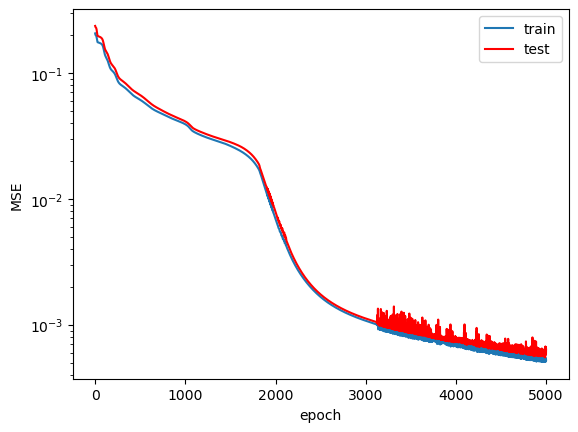

In [18]:
plt.plot([i for i in range(num_epochs)], mean_train_loss_vals[:, 0], label="train")
plt.plot([i for i in range(num_epochs)], mean_test_loss_vals[:, 0], color="r", label="test")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()

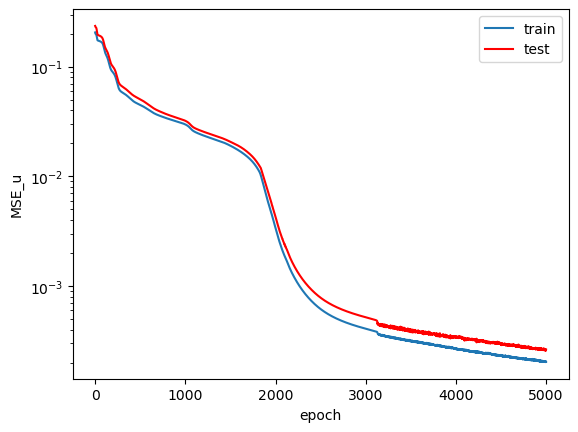

In [19]:
plt.plot([i for i in range(num_epochs)], mean_train_loss_vals[:, 1], label="train")
plt.plot([i for i in range(num_epochs)], mean_test_loss_vals[:, 1], color="r", label="test")
plt.xlabel("epoch")
plt.ylabel("MSE_u")
plt.yscale("log")
plt.legend()
plt.show()

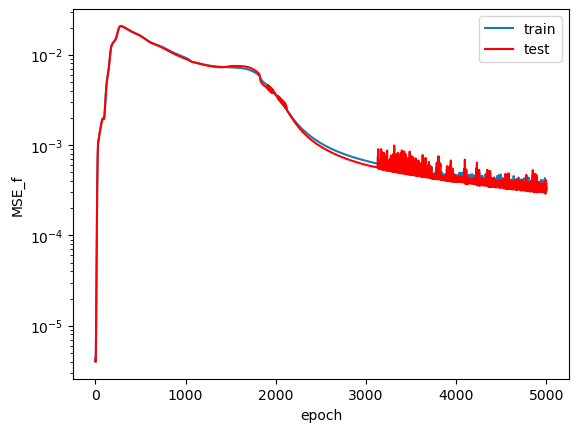

In [20]:
plt.plot([i for i in range(num_epochs)], mean_train_loss_vals[:, 2], label="train")
plt.plot([i for i in range(num_epochs)], mean_test_loss_vals[:, 2], color="r", label="test")
plt.xlabel("epoch")
plt.ylabel("MSE_f")
plt.yscale("log")
plt.legend()
plt.show()

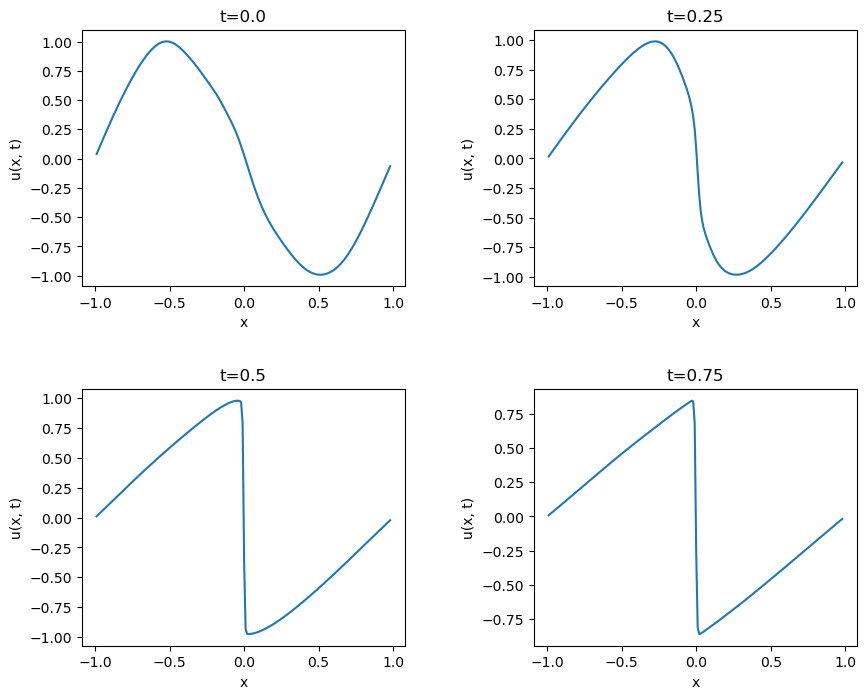

In [17]:
fixed_t = [0., 0.25, 0.5, 0.75]
x_vals = torch.tensor(np.arange(-0.99, 0.99, 0.01), requires_grad=True).reshape(-1, 1).to(device)
plt.figure(figsize=(10, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i, t in enumerate(fixed_t):
    t_vals = torch.tensor([t] * x_vals.shape[0], requires_grad=True).reshape(-1, 1).to(device)
    pred_u = pinn.forward_bci(x_vals, t_vals)
    plt.subplot(2, 2, i + 1)
    plt.plot(x_vals.detach().cpu().numpy(), pred_u.detach().cpu().numpy())
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.title(f"t={t}")
plt.show()